# Q Learning (Off Policy) with experience replay

We will be using **TD control method of Q Learning** on Cliff World environment as given below:  

![GridWorld](./images/cliffworld.png "Cliff World")


### Q Learning Update equation (remains same)

Q Learning control is carried by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. The Update equation is given below:

$$ 
\DeclareMathOperator*{\max}{max} Q(S,A) \leftarrow Q(S,A) + \alpha * [ R + \gamma * \max_{A'} Q(S’,A’) – Q(S,A)] $$


In experience replay, we store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using Q-values. Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. The process makes learning efficient by reusing a sample multiple times. Rest of the approach remains same. 

In [1]:
# Initial imports and environment setup
import sys
import gymnasium as gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Q Learning Learning agent class
from collections import defaultdict


class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # Q learning update step
    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + self.gamma * \
                self.get_Q(next_state, best_next_action) - \
                self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy for exploration
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [3]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.show()

In [4]:
# helper function to print policy under Cliff world
def print_policy(env, agent):

    _cliff = np.zeros(env.shape, dtype=bool)
    _cliff[3, 1:-1] = True    
    nR, nC = _cliff.shape

    actions = '^>v<'

    for y in range(nR):
        for x in range(nC):
            if _cliff[y, x]:
                print(" C ", end='')
            elif (y * nC + x) == env.start_state_index:
                print(" X ", end='')
            elif (y * nC + x) == nR * nC - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.max_action(y * nC + x)], end='')
        print()

#### Replay Buffer

In [5]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size  # max number of items in buffer
        self.buffer = []   # array to hold buffer

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        self.buffer = self.buffer[-self.size:] + [item]

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return states, actions, rewards, next_states, done_flags

In [6]:
# training algorithm with reply buffer
def train_agent(env, agent, episode_cnt=10000, tmax=10000,
                anneal_eps=True, replay_buffer=None, batch_size=16):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state, _ = env.reset()
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)
            if replay_buffer:
                replay_buffer.add(state, action, reward, next_state, done)
                states, actions, rewards, next_states, done_flags = \
                        replay_buffer(batch_size)
                for i in range(batch_size):
                    agent.update(states[i], actions[i], rewards[i],
                                 next_states[i], done_flags[i])
            else:
                agent.update(state, action, reward, next_state, done)

            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

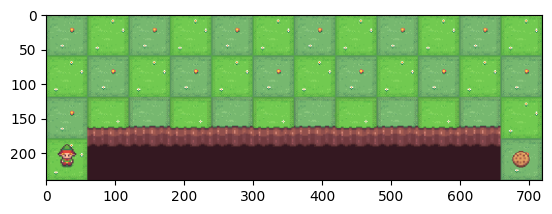

In [7]:
# create cliff world environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

In [8]:
# create a Q Learning agent
agent = QLearningAgent(alpha=0.25, epsilon=0.2, gamma=0.99, 
                       get_possible_actions=lambda s : range(env.nA))

# train agent using replay buffer and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt=5000, 
                      replay_buffer=ReplayBuffer(512))

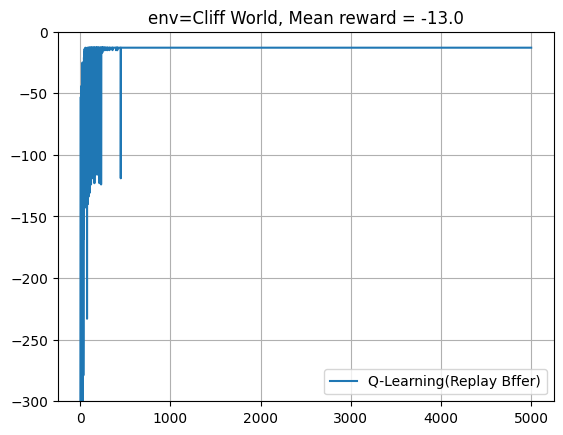

In [9]:
# plot per episode reward
plot_rewards("Cliff World", rewards, 'Q-Learning(Replay Bffer)')

In [10]:
# print policy learnt by the agent
print_policy(env, agent)

 ^  ^  ^  v  ^  ^  >  >  >  >  v  ^ 
 <  >  v  >  >  >  >  >  >  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### Q Learning for "Taxi" environment 

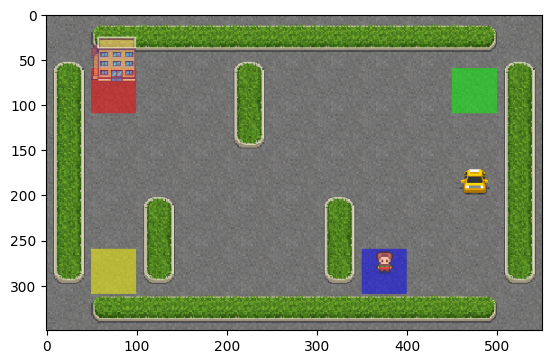

In [11]:
# create taxi environment
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

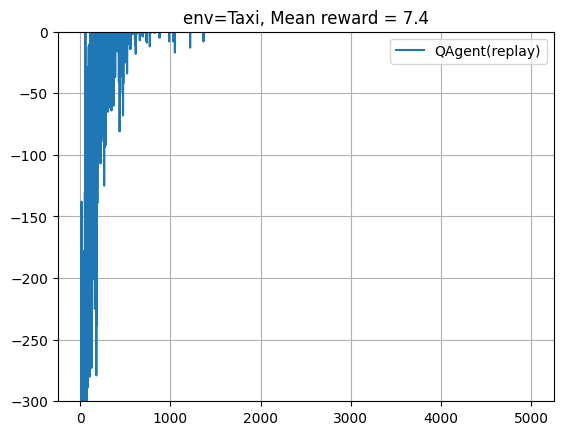

In [12]:
# create a Q Learning agent
agent = QLearningAgent(alpha=0.25, epsilon=0.2, gamma=0.99,
                       get_possible_actions=lambda s : range(env.action_space.n))

#train agent with replay buffer and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt=5000, 
                      replay_buffer = ReplayBuffer(512))

#plot reward graph
plot_rewards("Taxi", rewards, 'QAgent(replay)')

In [13]:
# plot rewards
def plot_rewards_compare(env_name, rewards, labels):
    for i in range(len(rewards)):
        reward_list = rewards[i]
        label = labels[i] + '. mean={:.1f}'.format(np.mean(reward_list[-20]))
        plt.title("env={}".format(env_name))
        plt.plot(rewards[i], label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.show()

### Conclusion

Q agent with replay buffer is supposed to improve the initial convergence by sampling repeatedly from the buffer. Sample efficiency will become more apparent when we look at DQN. Over long run, there won't be any significant difference between the optimal values learnt with or without Replay Buffer. It has another advantage of breaking correlation between samples. This aspect will also become apparent when we look at Deep Learning with Q-Learning i.e. DQN. 